In [1]:
import requests
from PIL import Image
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy

/home/hasan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import numpy as np
from scipy.stats import skew
from scipy.stats import entropy

def plot_bucket_distribution(batch_id, attention_scores, vision_token_budget=100, subject_layers=[0], background_layers=[22], num_vision_tokens=576):
    # attention_scores: list of tensors shape: [batch_size, num_heads, num_context, num_context]
    # vision_token_budget: int always less than num_vision_tokens
    # subject_layers: list of int
    # background_layers: list of int
    # num_vision_tokens: int, usually 576

    # Extract and sum attention scores for the specified layers
    sub_attn_scores = torch.stack([attention_scores[i][batch_id, :, 0, -num_vision_tokens:] for i in subject_layers])  # [num_layers, num_heads, num_vision_tokens]
    sub_attn_scores = sub_attn_scores.sum(dim=0)  # [num_heads, num_vision_tokens]
    sub_attn_scores = sub_attn_scores.sum(dim=0)  # [num_vision_tokens]
    sub_attn_scores = sub_attn_scores/ sub_attn_scores.sum() 
    sub_attn_scores = sub_attn_scores.cpu().numpy()

    bg_attn_scores = torch.stack([attention_scores[i][batch_id, :, 0, -num_vision_tokens:] for i in background_layers])  # [num_layers, num_heads, num_vision_tokens]
    bg_attn_scores = bg_attn_scores.sum(dim=0)  # [num_heads, num_vision_tokens]
    bg_attn_scores = bg_attn_scores.sum(dim=0)  # [num_vision_tokens]
    bg_attn_scores = bg_attn_scores / bg_attn_scores.sum()
    bg_attn_scores = bg_attn_scores.cpu().numpy()

    # sort and get the index for the topk tokens
    sub_topk_idx = np.argsort(sub_attn_scores)[::-1][:vision_token_budget]
    bg_topk_idx = np.argsort(bg_attn_scores)[::-1][:vision_token_budget]

    union_idx = np.union1d(sub_topk_idx, bg_topk_idx)

    # size of union
    print(f"Size of union: {len(union_idx)}")




def select_topk_tokens(batch_id,attention_scores, num_topk=200, layers_in_use=[0,22], num_vision_tokens=576):
    # attention_scores: tuples of tensors shape: [batch_size, num_heads, num_context, num_context]
    # num_topk: int
    # layers_in_use: list of int
    # num_vision_tokens: int, usually 576

    attention_scores = torch.stack([attention_scores[i][0,:,0,-num_vision_tokens:] for i in layers_in_use]) # [num_layers, num_heads, num_vision_tokens]
    attention_scores = attention_scores.sum(dim=0) # [num_heads, num_vision_tokens]
    attention_scores = attention_scores.sum(dim=0) # [num_vision_tokens]

    skewness = skew(attention_scores.cpu().numpy())
    print(f"The Skewness: {skewness}")




In [3]:
model_id = "llava-hf/llava-1.5-7b-hf"

In [4]:
model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
    attn_implementation="eager",
).to(0)
processor = AutoProcessor.from_pretrained(model_id)

/home/hasan/my_llava_next/transformers/src/transformers/models/llava/configuration_llava.py:100: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### run from down below

In [15]:
url = "https://picsum.photos/400"
response = requests.get(url)

if response.status_code == 200:
    with open('image.jpg', 'wb') as file:
        file.write(response.content)
    print("Image successfully retrieved and saved.")
else:
    print(f"Failed to retrieve image. HTTP Status code: {response.status_code}")
raw_image = Image.open('image.jpg')
simple_image = Image.open('simple_image.png')
text_image = Image.open('text_image.jpg')

Image successfully retrieved and saved.


In [16]:
images = [raw_image,simple_image,text_image]

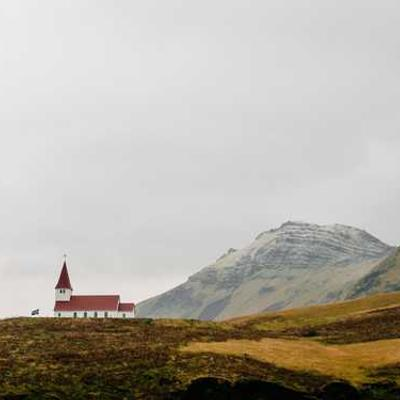

Size of union: 283


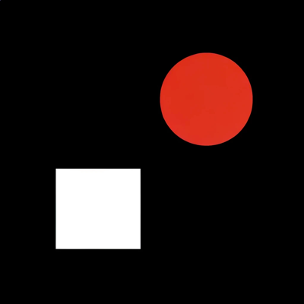

Size of union: 295


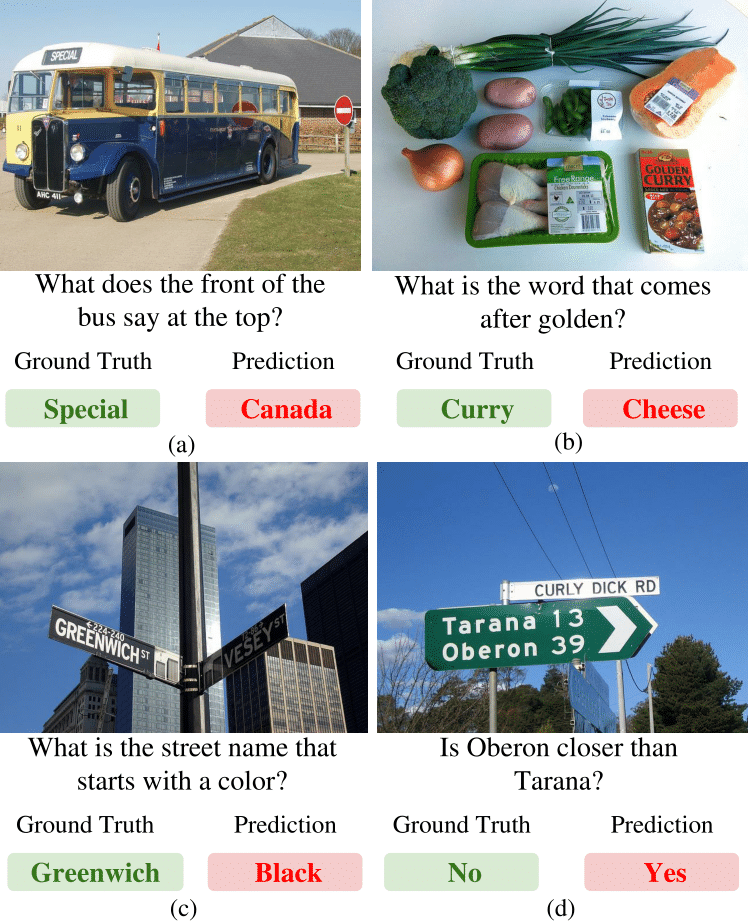

Size of union: 303


In [21]:
for image in images:
    image.show()
    prompt = "USER: <image>\nDescribe the image.\nASSISTANT:"
    inputs = processor(prompt, image, return_tensors='pt').to(0, torch.float16)
    with torch.inference_mode():
        output = model(**inputs, output_attentions=True, return_dict = True)

    vit_attentions = output.vit_attentions
    plot_bucket_distribution(0, vit_attentions, vision_token_budget=200, subject_layers=[0], background_layers=[22], num_vision_tokens=576)
